# Evaluation
One of the key requirements in developing a recommendation algorithm is to measure it's  effectiveness. Typical metrics include mean squared error, root mean squared error, precision and recall. It must be noted that evaluating performance on a fixed test dataset will be biased as it is impossible to accurately predict the reactions of real users to the recommendations. Hence, any metric computed on static data will be some-what imprecise. Of course, in real-world settings, this is overcome by online A/B tests. 

In this investigation, we set a small amount of users as hold-out for evaluation, fitting a model to all of the remaining users and artists. From these 'evaluation users', 15 of their interactions data is set as a hold-out test set, while their latent factors are computed using the rest of the data and the previously fitted model from the other users.Then , the top-k recommendations for each user are collected. These top-k artists are compared against the hold-out test items (15 in total), seeing how well they do at ranking them near the top vs. how they rank the remainder of the items.

As the data is implicit, the evaluation criteria  is akin to Information retrieval systems. The metrics we will use include:


- *P@k (“precision-at-k”)*: This metric calculates the proportion of the top-k  recommendations that include items from the test set for a given user - i.e.
$$
  P@k =
  \frac{1}{k}
  \sum_{i=1}^{k}
  \begin{cases}
    1 & \text{if $r_{i} \in \tau $} \\
    0 & \text{otherwise}
  \end{cases}
  $$
Where $r_{i}$ is the item ranked at position i by the model (sorting the predicted scores in descending order), and $\tau$ is the set of items that are in the test set for that user. Then, we calculate the mean and standard deviation  of these values to allow for comparison between the models. 

- R@k (“recall-at-k”): while P@k captures what a recommender system aims at being good at, it does not capture the fact that, the more test items there are, the higher the chances that they will be included in the top-K recommendations. The test set includes 15 items for each user. This metric examines the  proportion of the test artists would have been retrieved with the top-k recommended list:
$$
  R@k =
  \frac{1}{|\tau|}
  \sum_{i=1}^{k}
  \begin{cases}
    1 & \text{if $r_{i} \in \tau $} \\
    0 & \text{otherwise}
  \end{cases}
  $$
Again, we take the mean and standard deviation of this metric to allow comparison.



- Hit@k (“Hit Rate at k” ): This is a simple Binary metric that examines whether any of the top-k recommended artists were in the test set for a given user:
$$
  \max_{{i=1...k}}=
  \begin{cases}
    1 & \text{if $r_{i} \in \tau $} \\
    0 & \text{otherwise}
  \end{cases}
  $$
Again, we take the mean and standard deviation of this metric to allow comparison.

## Quick links:
- [Setup](#setup)
- [Overall Evaluation](#overall-evaluation)
    - [K = 5](#evaluation-matrix-at-k=5)
    - [K = 10](#evaluation-matrix-at-k=10)
    - [K = 15](#evaluation-matrix-at-k=15)
- [Drilling deeper](#drill-down-deeper)
    - [Diversity](#diversity)
        - [K = 5](#diversity-k=5)
        - [K = 10](#diversity-k=10)
        - [K = 15](#diversity-k=15)
    - [Mainstream](#mainstream)
        - [K = 5](#mainstream-k-=-5)
        - [K = 10](#mainstream-k-=-10)
        - [K = 15](#mainstream-k-=-15)
    - [Activity](#activity)
        - [K = 5](#activity-k-=-5)
        - [K = 10](#activity-k-=-5)
        - [K = 15](#activity-k-=-5)
    

## Setup
Importing the required data files and libraries. We also define the functions required for each metric in this section. Please view the function string for more in-depth explanation. 

In [1]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

vanilla_dot_pred = pd.read_csv('data/evaluation/vannila_dot_pred.csv')
vanilla_cos_pred = pd.read_csv('data/evaluation/vanila_cos_pred.csv')
reg_dot_pred = pd.read_csv('data/evaluation/reg_dot_pred.csv')
reg_cos_pred = pd.read_csv('data/evaluation/reg_cos_pred.csv')
test_set = pd.read_csv('data/evaluation/test-set.csv')
user_taggedartists = pd.read_csv(r'data/user_taggedartists-timestamps.dat', sep='\t')
user_artists = pd.read_csv('data/user_artists.dat', sep='\t')

In [2]:
def calculate_precision(model_recommended_items,test_set, k, unique_users=test_set.userID.unique()):
    """Calculate precision as defined above
    Args:
        model_recommended_items: a dataframe containing userIDs, their top 15 artists by a defined model, and the correspnding scores.
        test_Set: the test set as defined above, contains 20 items
    Returns:
        the mean and standard deviation of the precision values of the users
    """
    precision_score_list = []
    model_recommended_items = model_recommended_items[model_recommended_items.userID.isin(test_set.userID.values)]
    for curr_userID in unique_users:
        recommended_artistIDs =  ast.literal_eval(model_recommended_items[model_recommended_items.userID == curr_userID]["predictions_artists"].values[0])[0:k]
        test_artist_ids = ast.literal_eval(test_set[test_set.userID == curr_userID]["holdout_artists"].values[0])
        common_count = len(set(recommended_artistIDs).intersection(set(test_artist_ids)))
        precision_score_list.append(common_count/k)

    return (np.mean(precision_score_list), np.std(precision_score_list))

    
    
def calculate_recall(model_recommended_items,test_set, k, unique_users=test_set.userID.unique()):
    """Calculate recall as defined above
    Args:
        model_recommended_items: a dataframe containing userIDs, their top 15 artists by a defined model, and the correspnding scores.
        test_Set: the test set as defined above, contains 20 items
    Returns:
        the mean and standard deviation of the recall values of the users
"""
    recall_score_list = []
    model_recommended_items = model_recommended_items[model_recommended_items.userID.isin(test_set.userID.values)]
    for curr_userID in unique_users:
        recommended_artistIDs =  ast.literal_eval(model_recommended_items[model_recommended_items.userID == curr_userID]["predictions_artists"].values[0])[0:k]
        test_artist_ids = ast.literal_eval(test_set[test_set.userID == curr_userID]["holdout_artists"].values[0])
        common_count = len(set(recommended_artistIDs).intersection(set(test_artist_ids)))
        recall_score_list.append(common_count/ len(test_artist_ids))

    return (np.mean(recall_score_list), np.std(recall_score_list))

def calculate_hit_rate(model_recommended_items,test_set, k, unique_users=test_set.userID.unique()):
    """Calculate hit-rate as defined above
    Args:
        model_recommended_items: a dataframe containing userIDs, their top 15 artists by a defined model, and the correspnding scores.
        test_Set: the test set as defined above, contains 20 items
    Returns:
        the mean and standard deviation of the hit-rate values of the users
    """
    hit_rate_score_list = []
    model_recommended_items = model_recommended_items[model_recommended_items.userID.isin(test_set.userID.values)]
    for curr_userID in unique_users:
        recommended_artistIDs =  ast.literal_eval(model_recommended_items[model_recommended_items.userID == curr_userID]["predictions_artists"].values[0])[0:k]
        test_artist_ids = ast.literal_eval(test_set[test_set.userID == curr_userID]["holdout_artists"].values[0])
        common_count = len(set(recommended_artistIDs).intersection(set(test_artist_ids)))
        if common_count > 0:
            common_count = 1
        hit_rate_score_list.append(common_count)
    return (np.mean(hit_rate_score_list), np.std(hit_rate_score_list))

In [3]:
model_names_variable_dict = {
    "SGD_Matrix_Fact_vanilla_dot": vanilla_dot_pred,
    "SGD_Matrix_Fact_vanilla_cosine":vanilla_cos_pred,
    "SGD_Matrix_Fact_regularized_dot":reg_dot_pred,
    "SGD_Matrix_Fact_regularized_cosine":reg_cos_pred,
#    "Softmax_dot": None,
 #   "Softmax_cosine":None
}

## Overall Evaluation 

Now, we construct the evaluation matrix. In this evaluation matrix, the index is the the various model configurations in the format of *<Model_name>_<Similairty_meausre>*.  The columns specify the metrics used in the format *<metric_name>_at_<k_value>__<mean/standard_deviation>*. An individual evaluation matrix is computed for each value of k to keep it presentable.

In [4]:
# create evaluation matrix
def create_evaluation_matrix_at_k(k):
    """create evualtion matrix for a value of k"""
    evaluation_matrix = pd.DataFrame()
    for model_name, variable_name in model_names_variable_dict.items():
        temp_dict = {}
        temp_dict['model_name'] = model_name
        temp_dict[f'p_at_{k}_mean'] =  [calculate_precision(variable_name, test_set, k)[0]]
        temp_dict[f'r_at_{k}_mean'] =  [calculate_recall(variable_name, test_set, k)[0]]
        temp_dict[f'hr_at_{k}_mean'] =  [calculate_hit_rate(variable_name, test_set, k)[0]]
        temp_dict[f'p_at_{k}_stdv'] = [calculate_precision(variable_name, test_set, k)[1]]
        temp_dict[f'r_at_{k}_stdv'] = [calculate_recall(variable_name, test_set, k)[1]]
        temp_dict[f'hr_at_{k}_stdv'] = [calculate_hit_rate(variable_name, test_set, k)[1]]
        temp_df = pd.DataFrame(temp_dict)
        evaluation_matrix = pd.concat([evaluation_matrix, temp_df])
    return evaluation_matrix


#### Evaluation matrix at k=5

In [5]:
create_evaluation_matrix_at_k(5)

,model_name,p_at_5_mean,r_at_5_mean,hr_at_5_mean,p_at_5_stdv,r_at_5_stdv,hr_at_5_stdv
0,SGD_Matrix_Fact_vanilla_dot,0.033387,0.011129,0.144928,0.087315,0.029105,0.352028
0,SGD_Matrix_Fact_vanilla_cosine,0.257112,0.085704,0.713366,0.221936,0.073979,0.452189
0,SGD_Matrix_Fact_regularized_dot,0.082662,0.027554,0.341922,0.126538,0.042179,0.474353
0,SGD_Matrix_Fact_regularized_cosine,0.268062,0.089354,0.758454,0.210525,0.070175,0.428020


#### Evaluation matrix at k=10

In [6]:
create_evaluation_matrix_at_k(10)

,model_name,p_at_10_mean,r_at_10_mean,hr_at_10_mean,p_at_10_stdv,r_at_10_stdv,hr_at_10_stdv
0,SGD_Matrix_Fact_vanilla_dot,0.033924,0.022616,0.250671,0.067292,0.044861,0.433399
0,SGD_Matrix_Fact_vanilla_cosine,0.218894,0.145930,0.845947,0.160707,0.107138,0.360999
0,SGD_Matrix_Fact_regularized_dot,0.084326,0.056218,0.566828,0.092157,0.061438,0.495514
0,SGD_Matrix_Fact_regularized_cosine,0.247343,0.164895,0.893720,0.160956,0.107304,0.308196


#### Evaluation matrix at k=15

In [7]:
create_evaluation_matrix_at_k(15)

,model_name,p_at_15_mean,r_at_15_mean,hr_at_15_mean,p_at_15_stdv,r_at_15_stdv,hr_at_15_stdv
0,SGD_Matrix_Fact_vanilla_dot,0.036965,0.036965,0.348363,0.062706,0.062706,0.476452
0,SGD_Matrix_Fact_vanilla_cosine,0.189873,0.189873,0.908749,0.129153,0.129153,0.287965
0,SGD_Matrix_Fact_regularized_dot,0.083342,0.083342,0.703704,0.076630,0.076630,0.456623
0,SGD_Matrix_Fact_regularized_cosine,0.227232,0.227232,0.941492,0.133888,0.133888,0.234701


From these metrics, the best-performing models seem to be those that use the cosine similarity measure rather than the dot product. Cosine similarity only cares about *angle difference*, where as dot product cares about *angle and the magnitude*. Since artists that are more mainstream, i.e. have more user interactions, tend to have a higher norms, we hypothesis that models that incorporate this metric become biased towards mainstream artists and therefore fail to recommended niche artists. On the other hand, the  dot product is less expensive (in terms of complexity and implementation). It is safe to conclude that the addition of regularization on the SGD Matrix Factorization model provided it with a boost across all examined metrics. As we explained previously, regularization helps mitigate the “rich-get-richer” effect for popular artists. If our vanilla SGD matrix factorization formula was deployed into production, there is a risk users could become stuck in an “information confinement area”, leading to poor user experience and lost revenue. Regularization helps to mitigate against the model paying too much attention towards training data (low bias & high variance) which can lead to poor generalization. 

For the models that incorporate the cosine similarity, the precision value decreases as k increases. This is the desired result (rather than the inverse) as the objective of a good recommendation system is supply relevant recommendations near the top. We believe users are unlikely to look at more than the top five recommendations. It is interesting to note that the spread of precision values decreases as k increases for these models. This is an undesired result as they could be outliers biasing our mean value for earlier values of k and our subsequent conclusions.

For the models that incorporate the dot product, the precision
metrics remains relatively similar. This indicates the same proportion of relevant recommendations are produced for different values of K. Therefore, we would prefer the models that incorporated cosine similarity in production. 


Recall increase as K increases for most models. This is expected as there are more recommendations. For instance, the maximum recall value we can have @ 5 is 1/3, where @10 is 2/3. Comparing the model recall values and the maximum recall available,  the ability of these models to recommend relevant recommendations out of the relevant set is relatively proportionate across all K-values. Although the standard deviation of recall for most models increases as k increases. 

Hit rate is a simple metric, and increases as k increases due to the increasing number of recommendations the model is allowed to make. The standard deviation of this metric decrease as k increases. 



## Drill Down Deeper

As mentioned in the introduction section, just computing evaluation metrics across all users does not truly capture the effectiveness of a recommendation system. We decide to drill down deeper, viewing users in three separate ways based on their behaviour.

- *Diversity*: We are interested in how our systems perform for users with an uniform listening taste vs users with a varied taste.  We attach a diversity score to each user.
$$
 D_{i} =   \frac{1}{|J|}
 \sum_{j=1}^{|J|}
 tc_{j}
$$
where $J$ is the set of artists that user $i$ listened to and $tc_{j}$ represents the total number of unique tags (assigned by **all** users) belonging to artist $j$.
Of course, there is a cavet to this formulation, in that user's who  listen to more artists will generally have  have a higher score. This score is then used to divide the users into four distinct groups. 

- *"Following the crowd" users*: Users are divided into four groups of approximently equal size, depending on how mainstream their listening habitats are. First, we caulate the mainstreamness of an artist j:
$$
M_{j} =   \frac{1}{M}
 \sum_{i=1}^{M}
  \begin{cases}
    1 & \text{if $u_{i} \in \tau $} \\
    0 & \text{otherwise}
  \end{cases}
$$
where $\tau$ represents an artist's audience and $M$ is the the total number of users on the Last.fm Website.  User $i$'s mainstream listening habitat ($MH_{i}$) is then calculated as follows:
$$
 MH_{i} =   \frac{1}{J}
 \sum_{j=1}^{J}
 M_{j}
$$
where $J$ is the set of artists that user $i$ listened to. 





- *Activity on Last.fm*: Users are divided into four separate clusters of approximately equal size depending on their activity on the last.fm website. "Activity" is calculated for user i as follows:
$$
A_{i} = {\text{Total Number of plays}}
$$

For all semantic categories, quartile ranges $Q_{1}, Q_{2}, Q_{3}$ are utilised as cutting off points for their respective groups.


We now define helper functions to aid in this process. 

In [51]:
def catch(artist, desired_dict):
    "Not every artistID has a tag "
    try:
        return desired_dict[artist]
    except KeyError:
        return 0

def calculate_diversity_users(user_artists, user_taggedartists):
    """Calculate diversity score for each user
    Returns:
        a dict containing user id and diversity score
    """
    user_artists = user_artists[user_artists.userID.isin(test_set.userID.unique())]
    artist_tag_count_dict = user_taggedartists[["artistID", "tagID"]].groupby("artistID")["tagID"].nunique().to_dict()
    user_diversity_dict = {}
    for curr_userID in test_set.userID.unique():
        J = user_artists[user_artists.userID == curr_userID]['artistID'].unique()
        j_len = len(J)
        tc = sum([catch(artist,artist_tag_count_dict) for artist in J])
        user_diversity_dict[curr_userID] = tc/j_len
    return user_diversity_dict

def calculate_mainstream_users(user_artists):
    """Calculate mainstream score for each user
    Returns:
        a dict containing user id and mainstream score
    """
    user_artists = user_artists[user_artists.userID.isin(test_set.userID.unique())]
    M = len(test_set.userID.unique())
    user_mainstream_dict = {}
    artist_user_count_dict =  user_artists[["artistID", "userID"]].groupby("artistID")["userID"].nunique().to_dict()
    artist_user_count_dict = {k: v / M for k, v in artist_user_count_dict.items()}
    for curr_userID in test_set.userID.unique():
        J = user_artists[user_artists.userID == curr_userID]['artistID'].unique()
        j_len = len(J)
        tc = sum([artist_user_count_dict[artist] for artist in J])
        user_mainstream_dict[curr_userID] = tc/j_len
    return user_mainstream_dict

def calculate_activity(user_artists):
    """Calculate activity score for each user
    Returns:
        a dict containing user id and activity score
    """
    user_artists = user_artists[user_artists.userID.isin(test_set.userID.unique())]
    user_activity_dict = user_artists[["userID", "weight"]].groupby("userID").sum().to_dict()['weight']
    return user_activity_dict
    
def split_dict_into_four_groups(score_dict):
    """splits users IDS into four groups according to their score
            the 25th,50th,75th percentiles serve as splitting points
    Returns:
        four lists, one for each group 
    """
    Q1,Q2,Q3 = np.percentile(sorted(score_dict.values()), [25,50,75])
    group_1_ids, group_2_ids, group_3_ids, group_4_ids = [], [] ,[], []
    for user_id, score in score_dict.items():
        if score < Q1:
            group_1_ids.append(user_id)
        elif score >= Q1  and score < Q2:
            group_2_ids.append(user_id)
        elif score >= Q2  and score < Q3:
            group_3_ids.append(user_id)
        elif score >= Q3:
            group_4_ids.append(user_id)
    return group_1_ids, group_2_ids, group_3_ids, group_4_ids


In [9]:
def visualize_category_evaluation(groups, metric, k):
    """Does pre-processing to create a dataframe containing
    Returns:
        four lists, one for each group 
    """
    metric_func_dict = {
        'Precision': calculate_precision,
        'Recall': calculate_recall,
        'Hit Rate': calculate_hit_rate
    }
    category_df = pd.DataFrame()
    for model_name, variable_name in model_names_variable_dict.items():
        model_df = pd.DataFrame()
        for group, qauntile in zip(groups, ['<Q1', '[Q1,Q2)','[Q2,Q3)', '>Q3']):
            temp_dict = {}
            temp_dict['Model'] = model_name
            temp_dict['Quartile'] = qauntile
            temp_dict[f'{metric}_at_{k}_mean'] =  [metric_func_dict[metric](variable_name, test_set, k, group)[0]]
            temp_dict[f'{metric}_at_{k}_stdv'] = [metric_func_dict[metric](variable_name, test_set, k, group)[1]]
            temp_df = pd.DataFrame(temp_dict)
            model_df = pd.concat([model_df, temp_df], ignore_index=True)
        category_df = pd.concat([category_df,model_df ], ignore_index=True)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7), sharey=True)
    sns.lineplot(data=category_df, x="Quartile", y=f'{metric}_at_{k}_mean', hue="Model", ax=ax1).set(title=f'Mean {metric} at k = {k}', ylabel=f'{metric}')
    sns.lineplot(data=category_df, x="Quartile", y=f'{metric}_at_{k}_stdv', hue="Model", ax=ax2).set(title=f'Stand deviation {metric} at k = {k}', ylabel=f'{metric}')



### Diversity 
First, we plot the mean and standard deviation of the various evaluation metric values (described above), for each diversity group. **Note**, the group's (defined on the x axis) collective diversity score  increases as we move along the axis. For instance, the group labelled as "<Q1" represents a cluster of user IDs, where all of the user's diversity scores are less than the 25th global percentile. 
####  Diversity K=5

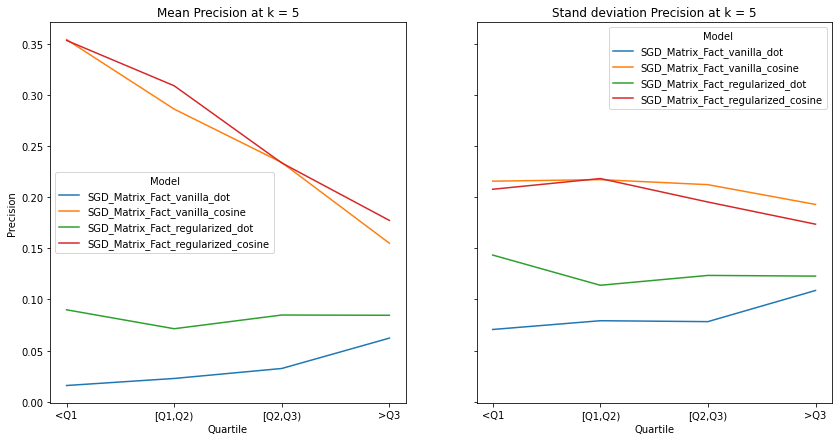

In [10]:
user_diversity_dict = calculate_diversity_users(user_artists, user_taggedartists)
visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Precision', k=5)

    

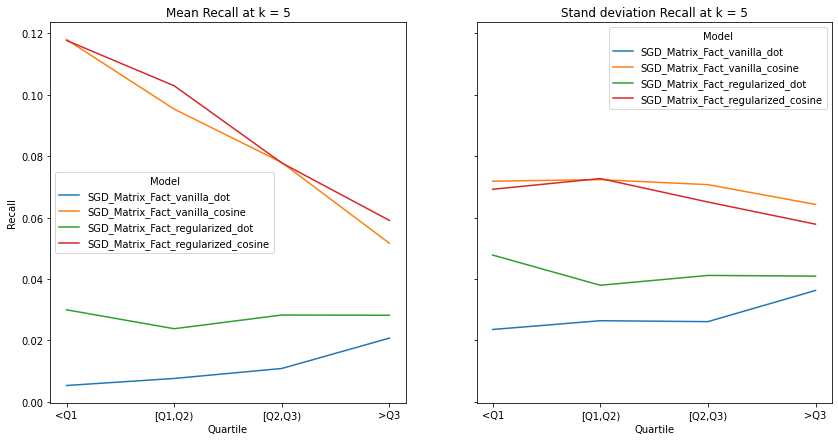

In [11]:
visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Recall', k=5)


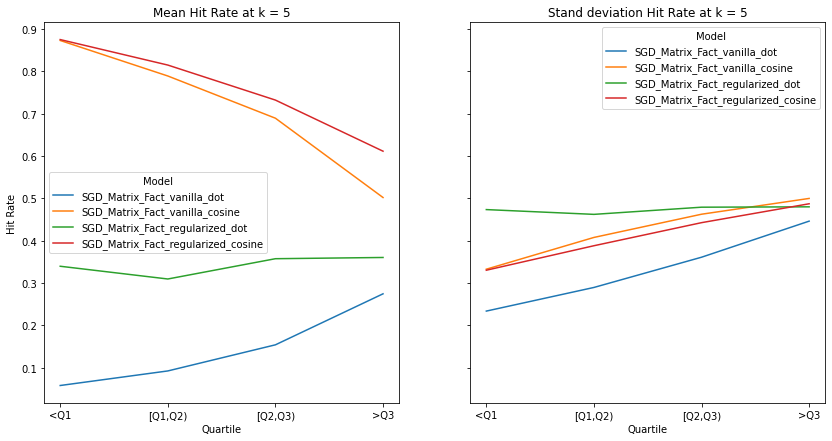

In [12]:
visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Hit Rate', k=5)


#### Diversity K=10

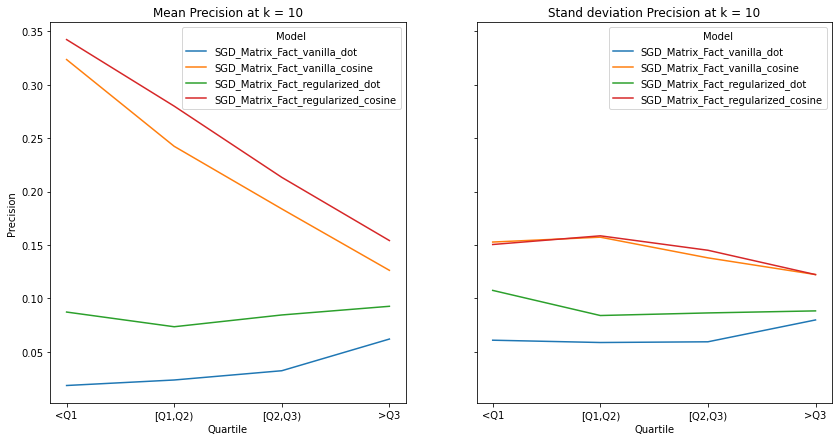

In [13]:
visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Precision', k=10)


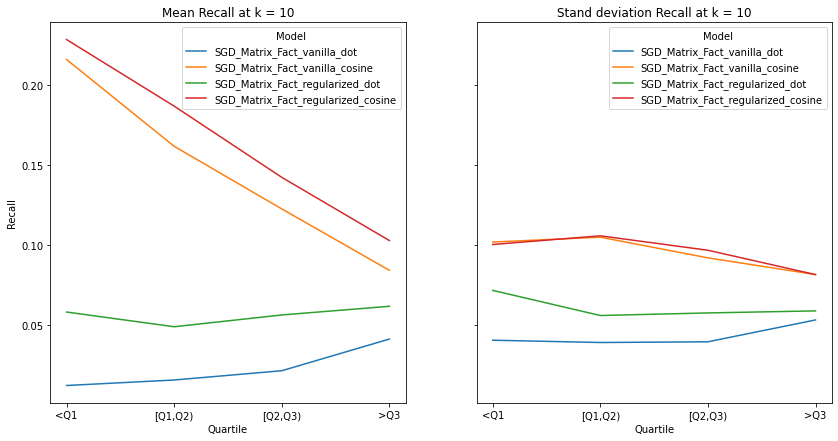

In [14]:

visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Recall', k=10)

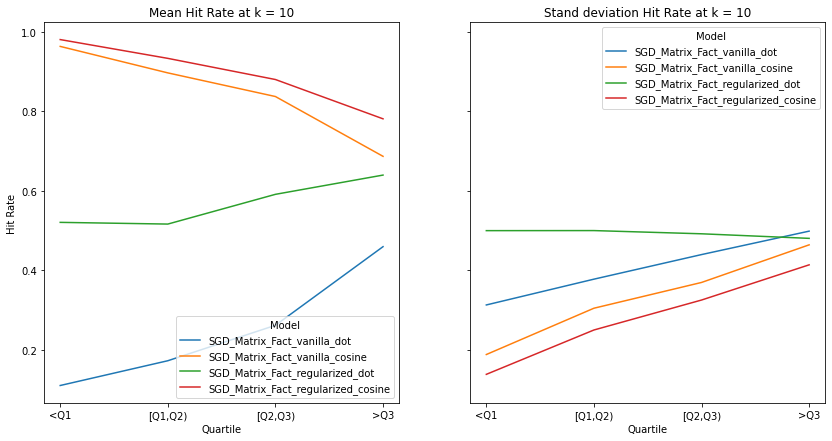

In [15]:

visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Hit Rate', k=10)

#### Diversity K=15

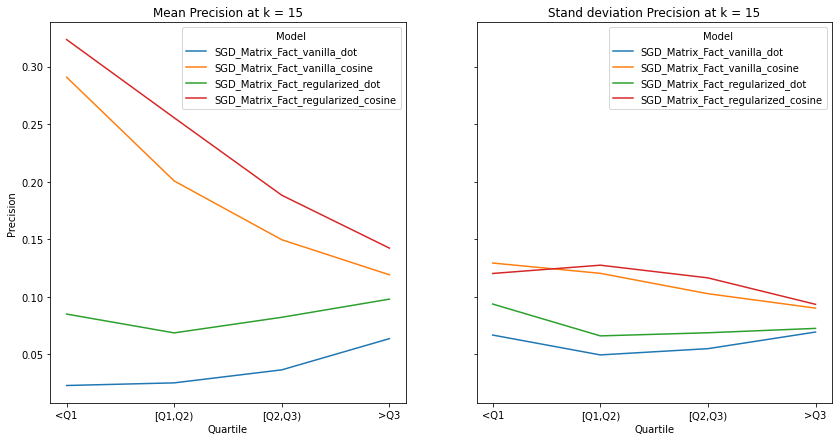

In [16]:
visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Precision', k=15)


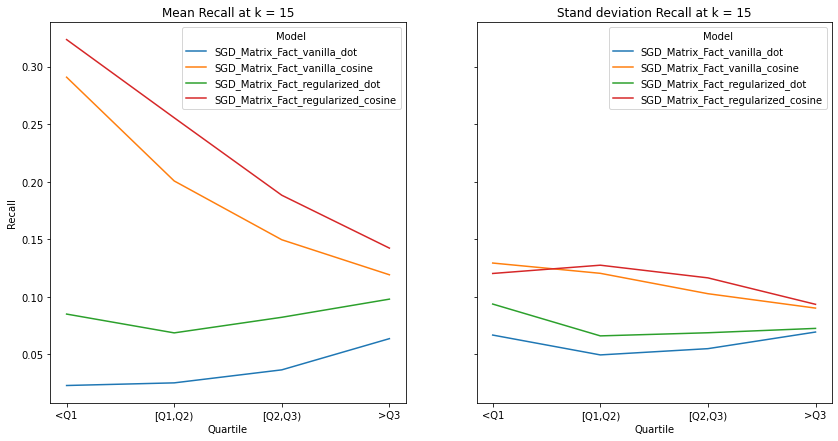

In [17]:

visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Recall', k=15)


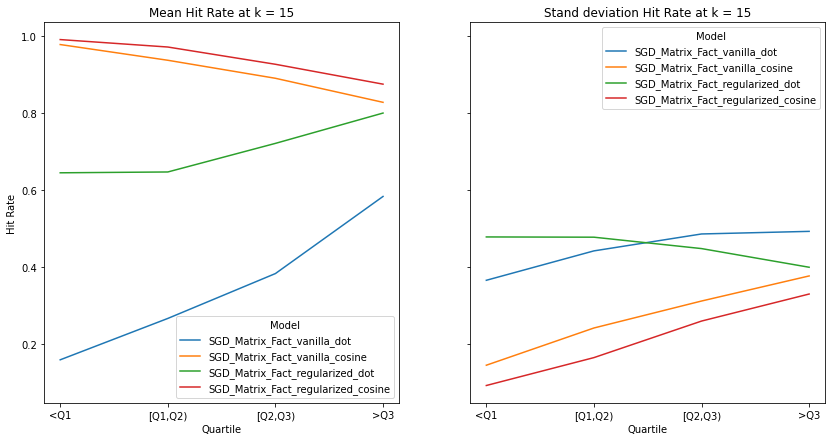

In [18]:

visualize_category_evaluation(split_dict_into_four_groups(user_diversity_dict), 'Hit Rate', k=15)
    

Music habits vary considerably across users. An ideal recommender system should be accurately meet the requirements of *all users*. There is a trend across all examined metrics that users with more uniform tastes are better served than those with a diverse set of tastes. We also notice similar observations as our overall evaluation, in terms of the trends of the precision, recall and hit-rate values for each value of K. The spread of the evaluation metrics either increases or stays the same as user's listening habitats become more diverse.

### Mainstream
Next, we plot the mean and standard deviation of the various evaluation metric values (described above), for each group of varying 'mainstreamness'. **Note**, the group's (defined on the x axis) collective mainstream score  increases as we move along the axis. For instance, the group labelled as "[Q1,Q2)" represents a group of user IDs, where all of the user's mainstream scores are less than the 50th global percentile, but greater than or equal to the 25th percentile.

#### Mainstream K = 5

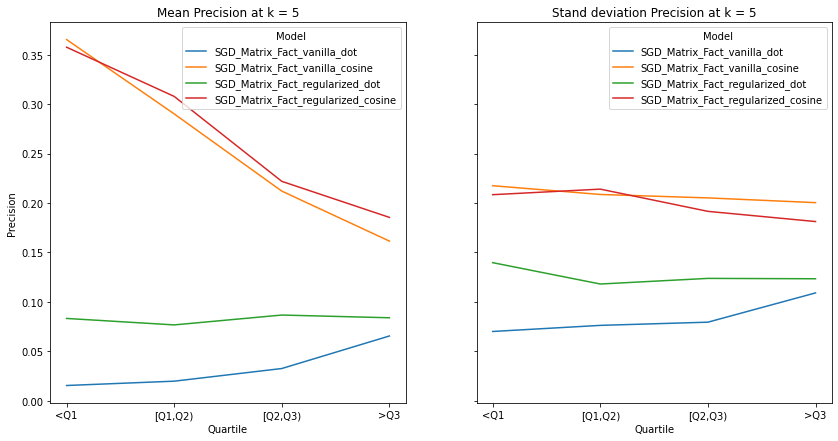

In [22]:
user_mainstream_dict = calculate_mainstream_users(user_artists)
visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Precision', k=5)

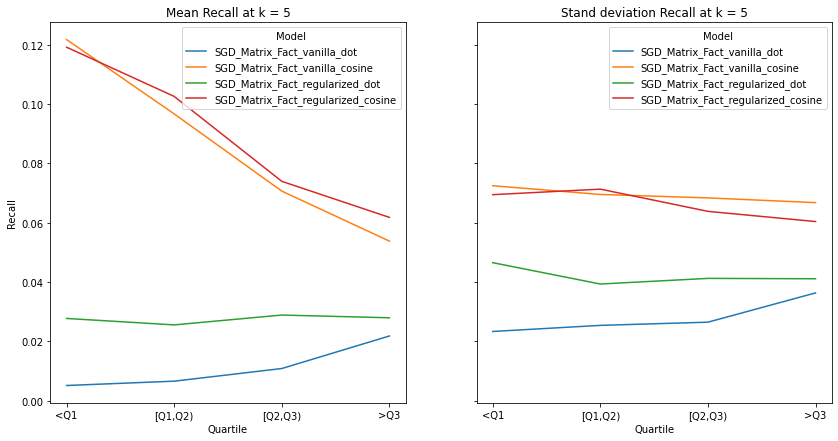

In [23]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Recall', k=5)


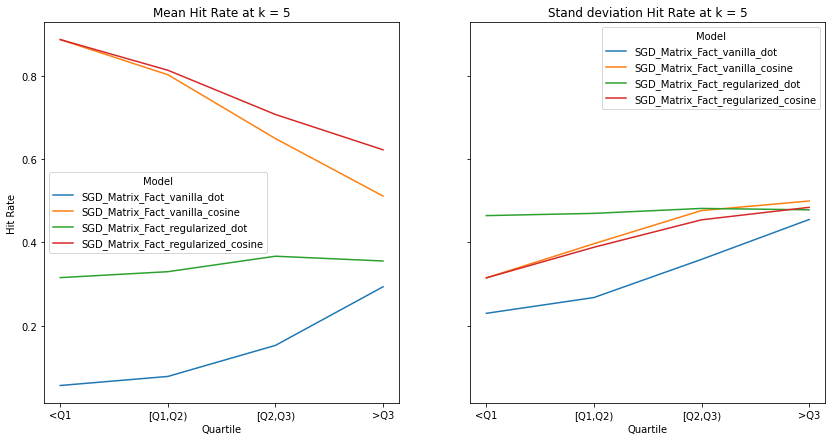

In [24]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Hit Rate', k=5)


#### Mainstream K = 10

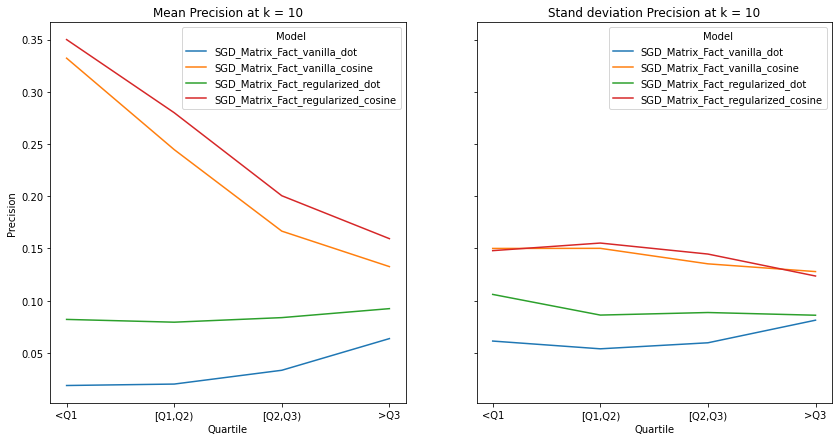

In [25]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Precision', k=10)


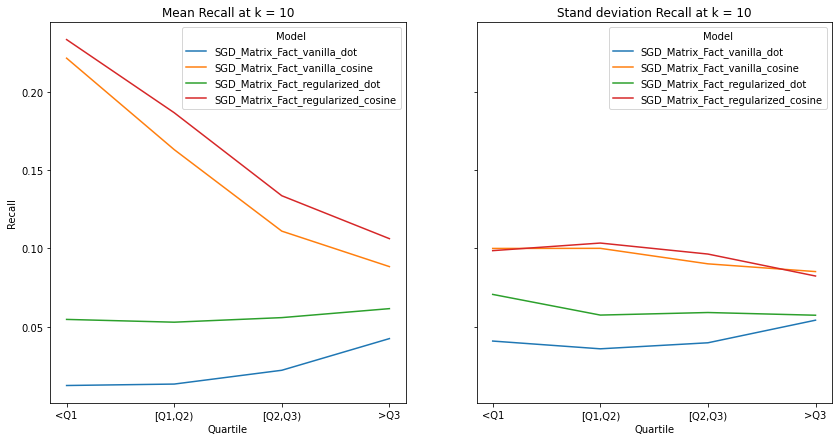

In [26]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Recall', k=10)


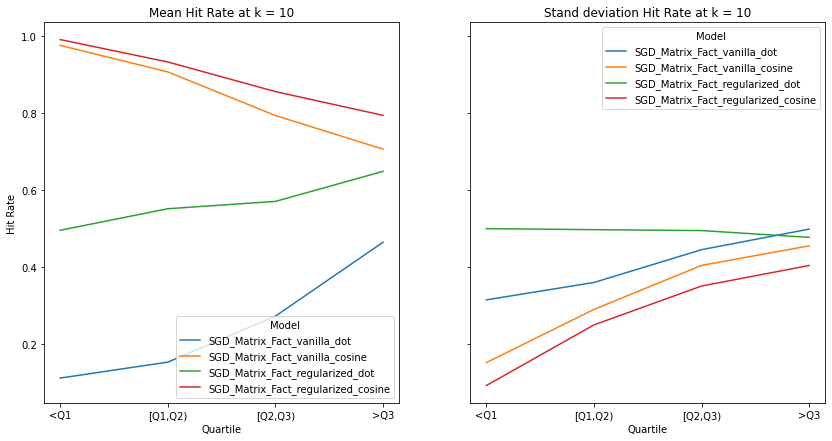

In [27]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Hit Rate', k=10)


#### Mainstream K = 15

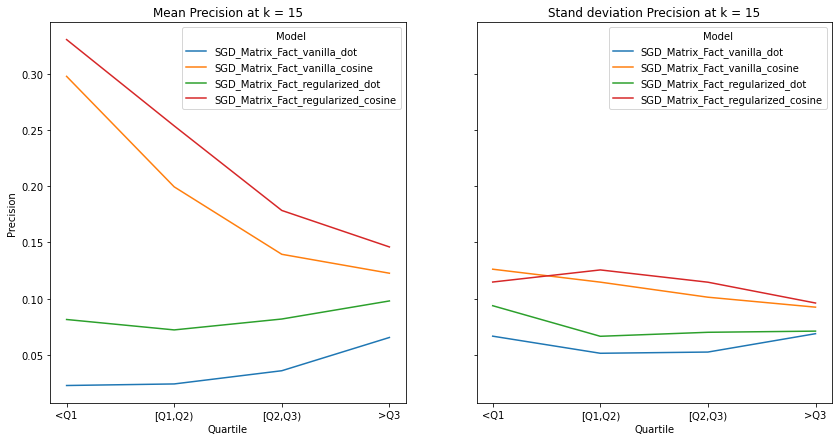

In [28]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Precision', k=15)


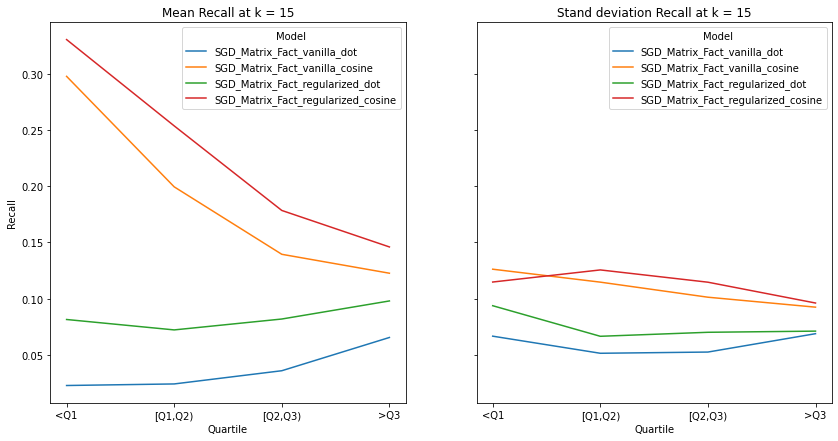

In [29]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Recall', k=15)


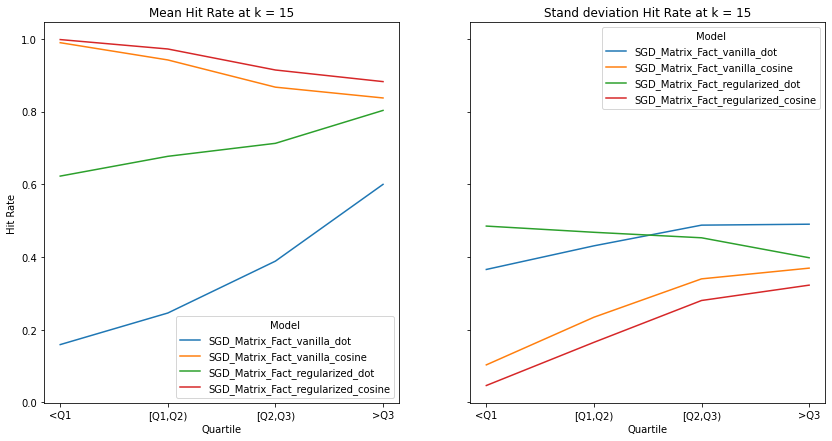

In [30]:

visualize_category_evaluation(split_dict_into_four_groups(user_mainstream_dict), 'Hit Rate', k=15)


An ideal artist recommender system should not alienate users with niche music habitats. We notice two main threads:
- the performance of the recommender systems that incorporates the **cosine similarity** **decreases** across much of the examined metrics as user's listening habitats become more mainstream. 
- the performance of the recommender systems that incorporates the **dot product** **increases** across much of the examined metrics as user's listening habitats become more mainstream.

These graphs make intitule sense and confirms our observation from our overall evaluation i.e. as dot product takes into account the norm of the vectors, it is more likely to benefits users that listen to mainstream artists. It must be noted that there is no discernable pattern in the spread of the evaluation metrics across mainstream groups. Although we do notice the same observations as our overall evualtion, ie the tendency of the spread to decrease as k increases. 

### Activity 

Finally, we plot the mean and standard deviation of the various evaluation metric values (described above), for each group of varying activity levels. **Note**, the group's (defined on the x axis) collective activity score increases as we move along the axis. We determine activity in terms of the number of plays a user has made on Last.fm, rather than the amount of artists they have listened to. For instance, the group labelled as ">Q3" represents a cluster of user IDs, where all of the user's activity scores are greater than the 75th global percentile. 

#### Activity k = 5 

In [52]:
user_activity_dict = calculate_activity(user_artists)

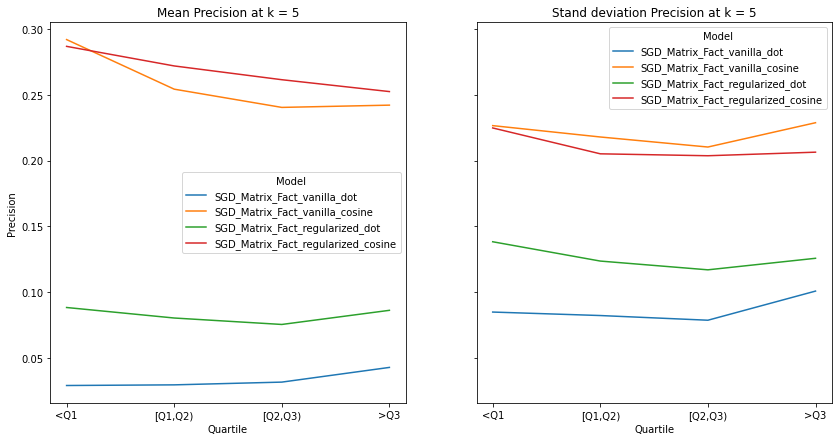

In [53]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Precision', k=5)


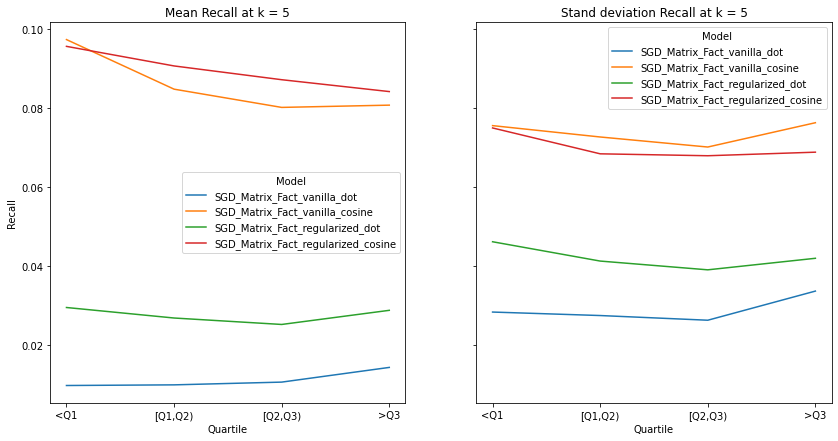

In [54]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Recall', k=5)


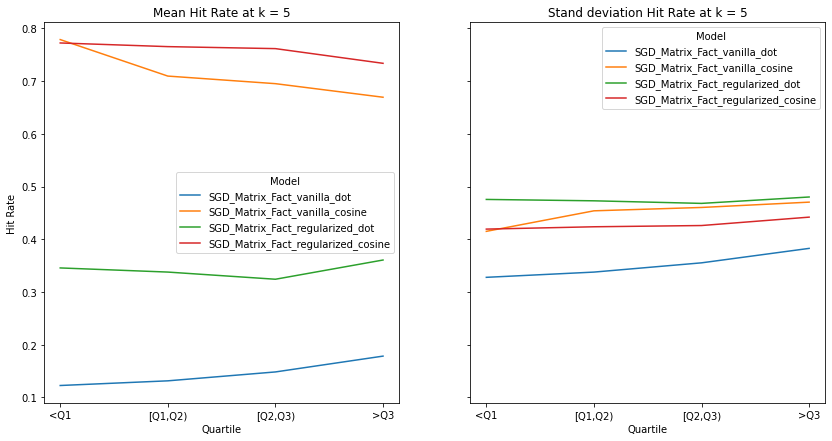

In [55]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Hit Rate', k=5)


#### k = 10

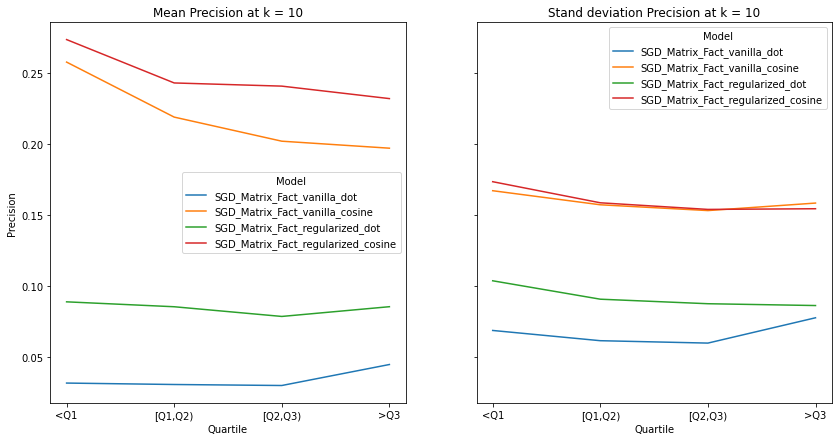

In [56]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Precision', k=10)


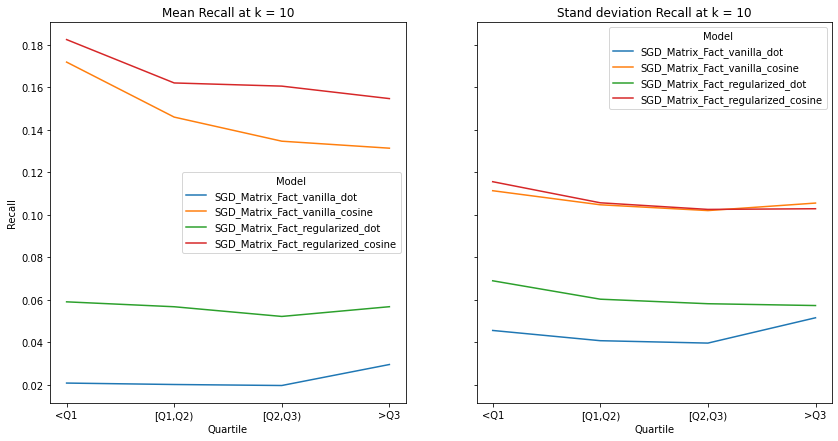

In [57]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Recall', k=10)


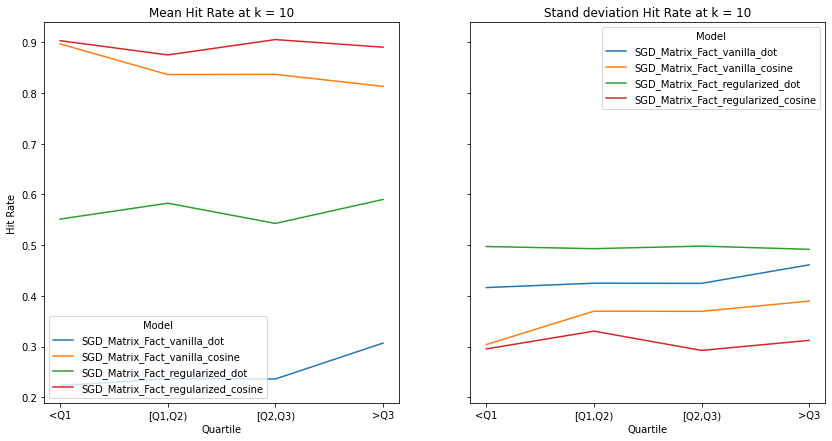

In [58]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Hit Rate', k=10)

#### K= 15

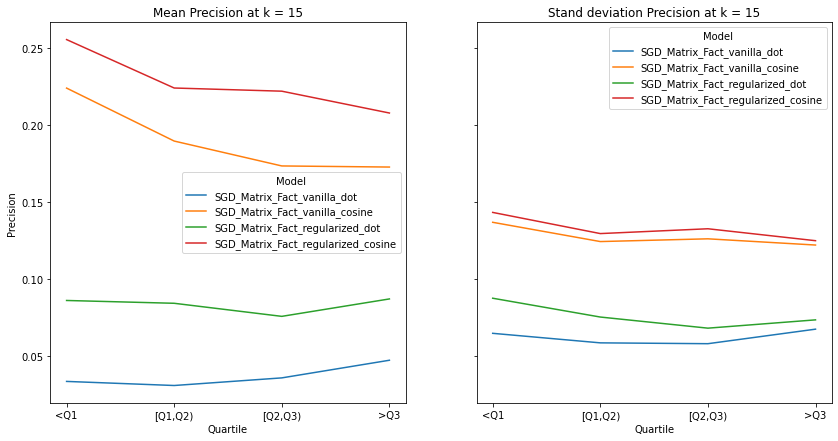

In [59]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Precision', k=15)


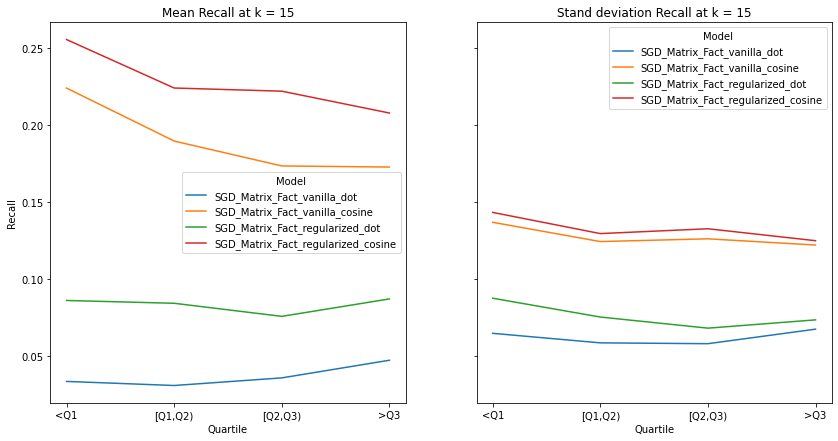

In [60]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Recall', k=15)


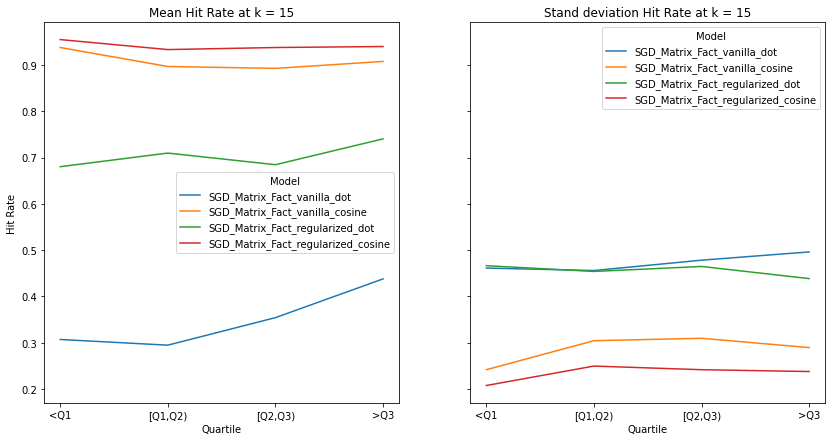

In [61]:

visualize_category_evaluation(split_dict_into_four_groups(user_activity_dict), 'Hit Rate', k=15)



There is no discernable trend or bias observed in terms our recommendation's systems ability to recommend items to users of different activity level. This makes intuitive sense as we use a binary matrix to encode user's interactions rather than min-max normalizing the listening counts. Perhaps if we did the latter, we would observe increased performance for user's who interact with Last.fm more. Although there is a slight trend that the performance of models with cosine similarity decrease with increased user activity where as those who incorporate the dot product increase, We also notice that regularization increases a model's performance significantly, indicating the model generalize well to user's with different listening habitats. 